# Candidate-Role Recommender System

The aim of this project is to come up with a solution capable of accurately suggest candidates suitable for a particular job advertisement. I will proceed by conducting some exploratory data analysis on the (randomly generated) datasets, to then proceed with the implementation of common matchmaking algorithms as well as machine learning regression and classification techniques. 
Finally, I will analyse the performance of each approach and select a suitable option.

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# set matplotlib inline styles
%matplotlib inline

# load the datasets into pandas dataframes
jobs = pd.read_csv('internshipsdata.csv')
candidates = pd.read_csv('studentsdata.csv')

In [27]:
# checkout the head of the jobs dataframe
jobs.head()

,Title,Company,Field,Min_score,Positions
0,Radiologic Technologist Placement,MediCare Innovations,nutrition,90,4
1,Registered Nurse Opportunity,LifeScience Labs,nutrition,84,3
2,Physician Placement,BioHealth Therapeutics,nursing,59,4
3,Medical Assistant Placement,LifeScience Labs,nutrition,95,5
4,Radiologic Technologist Placement,HealthPro Solutions,dentistry,58,7


In [30]:
# checkout the head of the candidates dataframe
candidates.head()

,Fullname,Course,Score,Experience,Study_mode,Study_pattern
0,Mark Garcia,Master of Public Health (M.P.H.),97,dentistry,on-campus,PT
1,Whitney Morgan,Doctor of Pharmacy (Pharm.D.),70,dentistry,online,FT
2,Stephanie Norman,Doctor of Dental Medicine (D.M.D.),58,dentistry,online,PT
3,Michael Oliver,Doctor of Dental Surgery (D.D.S.),75,nutrition,on-campus,PT
4,Andrea Smith,Master of Health Administration (M.H.A.),78,dentistry,online,PT


### Data cleaning

In this section, both dataframes are prepared for future data visualization and prepared according to the algorithm utilised. 

### Exploratory data visualization & analysis

In this section, the visualization libraries imported at the top of the notebook are put to use to plot both datasets and hopefully discover trends which could be relevant in the later stages of this experiment

<Axes: xlabel='Score', ylabel='Count'>

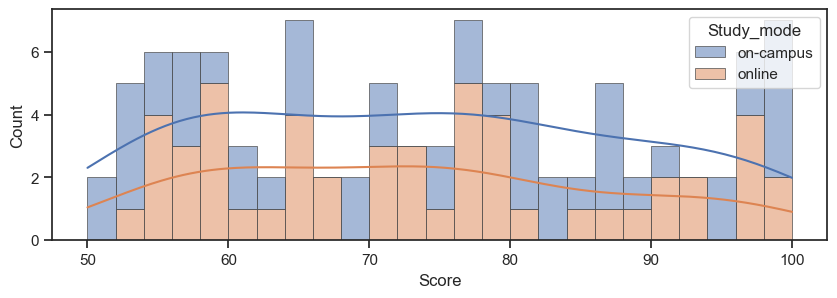

In [58]:
sns.set_theme(style="ticks")
sns.color_palette("flare", as_cmap=True)
plt.figure(figsize=(10, 3))

# histogram plot to check for trend in student score based on study-mode 
sns.histplot(data=candidates, x="Score", hue="Study_mode", multiple="stack", edgecolor=".3", linewidth=.5, bins=25, kde=True)

### Gale-Shapley Algorithm